# Building CNN from scratch


**Our Agenda:**
1.  **Setup & Data Loading**: Prepare our environment and the MNIST dataset.
2.  **Flexible Model Building**: Create a dynamic CNN class where we can easily change the **depth** and **activation function**.
3.  **Model Inspection with torchsummary**: Understand our network's architecture, layer outputs, and parameter counts.
4.  **Systematic Experiments**: Train multiple models to compare:
    * The effect of network depth (shallow vs. deep).
    * The effect of different non-linearities (ReLU, Leaky ReLU, Tanh).
5.  **Results Analysis**: Summarize our findings and draw conclusions about CNN design.

## Step 1: Import Libraries and Setup


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
import time

# Check if a GPU is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


## Step 2: Load and Prepare the MNIST Dataset


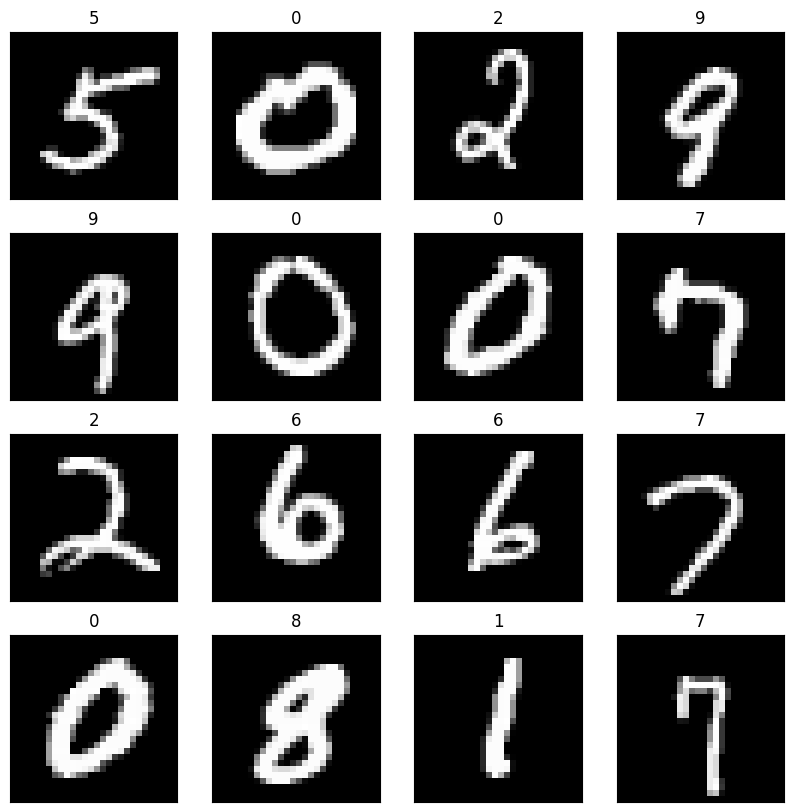

In [9]:
# Define the transformation pipeline
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download and load the data
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
batch_size = 128
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Visualize a few images
dataiter = iter(train_loader)
images, labels = next(dataiter)
fig = plt.figure(figsize=(10, 10))
for idx in np.arange(16):
    ax = fig.add_subplot(4, 4, idx+1, xticks=[], yticks=[])
    img = images[idx] / 2 + 0.5
    plt.imshow(np.squeeze(img), cmap='gray')
    ax.set_title(str(labels[idx].item()))
plt.show()

## Step 3: Build a Flexible CNN Model

Here, we define our `SimpleCNN` class. This architecture is powerful because it's **dynamic**. We can specify any integer `depth` and choose from several activation functions.

**Key Components:**
- **`nn.Conv2d`**: The core convolutional layer that learns features.
- **`nn.BatchNorm2d`**: Normalizes the activations from the convolutional layer. This stabilizes the network, prevents issues like vanishing/exploding gradients, and helps the model train faster and more reliably.
- **Activation Function**: Introduces non-linearity, allowing the model to learn complex patterns.
- **`nn.MaxPool2d`**: Downsamples the feature map, reducing its spatial dimensions. This makes the model more efficient and helps it learn features that are robust to small translations in the input image.
- **`nn.Sequential`**: A container that chains our layers together, making the forward pass clean and simple.
- **`nn.Linear`**: A standard fully connected layer for the final classification.

In [10]:
class SimpleCNN(nn.Module):
    # This class defines a flexible Convolutional Neural Network.
    # You can change its depth and activation function when you create it.

    def __init__(self, activation='relu', depth=2):
        """
        This is the constructor method. It sets up all the layers of the network.
        Args:
            activation (str): The name of the activation function to use ('relu', 'leakyrelu', 'tanh').
            depth (int): The number of convolutional blocks in the network.
        """
        # This line is essential. It calls the constructor of the parent class (nn.Module),
        # which is necessary for PyTorch to manage the model's layers and parameters.
        super(SimpleCNN, self).__init__()

        # --- 1. Choose the Activation Function ---
        # A dictionary is used to map the string name of an activation function
        # to its actual PyTorch layer object. This makes the code clean and easy to extend.
        activations = {
            'relu': nn.ReLU(),
            'leakyrelu': nn.LeakyReLU(0.1),
            'tanh': nn.Tanh()
        }
        # Look up the activation object from the dictionary based on the 'activation' argument
        # and store it as an attribute of this class.
        self.act = activations[activation]

        # --- 2. Dynamically Build the Convolutional Layers ---
        # We'll build the convolutional part of the network in a loop.

        # Create an empty list to hold the layers for our convolutional blocks.
        layers = []
        # Initialize 'in_channels' to 1 because the input MNIST images are grayscale (one channel).
        # This variable will be updated in each iteration of the loop.
        in_channels = 1

        # This loop runs 'depth' times. Each iteration adds one complete convolutional block.
        for i in range(depth):
            # Calculate the number of output channels (filters) for the current layer.
            # The formula 16 * (2**i) doubles the channels at each layer:
            # Layer 0 (i=0): 16 * 1 = 16 channels
            # Layer 1 (i=1): 16 * 2 = 32 channels
            # Layer 2 (i=2): 16 * 4 = 64 channels ...and so on.
            out_channels = 16 * (2**i)

            # --- Add a complete convolutional block to the 'layers' list ---
            # a) Convolutional Layer: Applies filters to the input.
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            # b) Batch Normalization: Stabilizes training and helps the model learn faster.
            layers.append(nn.BatchNorm2d(out_channels))
            # c) Activation Function: Introduces non-linearity.
            layers.append(self.act)
            # d) Max Pooling: Downsamples the feature map, reducing its height and width by half.
            layers.append(nn.MaxPool2d(2))

            # Update 'in_channels' for the *next* iteration of the loop.
            # The output channels of this layer become the input channels for the next one.
            in_channels = out_channels

        # --- 3. Wrap the Convolutional Layers in nn.Sequential ---
        # The * operator unpacks the 'layers' list.
        # nn.Sequential creates a single module that passes data through each layer in order.
        self.conv_layers = nn.Sequential(*layers)

        # --- 4. Define the Final Fully Connected (Classifier) Layer ---

        # Automatically calculate the size of the feature map after all conv/pool layers.
        # The initial image size is 28x28. Each MaxPool2d layer halves the dimensions.
        final_img_size = 28 // (2**depth)
        # The total number of features to be fed into the linear layer is:
        # (last number of channels) * (final height) * (final width)
        fc_input_features = in_channels * final_img_size * final_img_size

        # Create the final linear layer. It takes the flattened features and outputs 10 scores,
        # one for each digit class (0-9).
        self.fc = nn.Linear(fc_input_features, 10)

    def forward(self, x):
        """
        This method defines the forward pass of the network.
        It specifies how input data 'x' flows through the layers.
        Args:
            x (torch.Tensor): The input data (a batch of images).
        """
        # 1. Pass the input 'x' through all the convolutional blocks.
        x = self.conv_layers(x)

        # 2. Flatten the output from the convolutional layers.
        # The output is a 4D tensor: [batch_size, channels, height, width].
        # We flatten it into a 2D tensor: [batch_size, total_features]
        # so it can be processed by the linear layer. The '1' means we keep the batch dimension.
        x = torch.flatten(x, 1)

        # 3. Pass the flattened tensor through the final fully connected layer.
        # This produces the raw output scores (logits) for each class.
        x = self.fc(x)

        # 4. Return the final scores.
        return x


## Step 4: Inspect the Model with `torchsummary`

Before training, let's use torchsummary to understand what we've built. We'll create a model with depth=2 and look at its structure.

**How to Read the Summary:**
- **Layer (type)**: The name and type of the layer.
- **Output Shape**: The shape of the tensor after passing through that layer. [batch_size, channels, height, width].
- **Param #**: The number of trainable parameters in that layer.

**Intuition:** Watch how the dimensions change. The Conv2d and BatchNorm2d layers increase the number of channels (from 1 to 16, then 32), while MaxPool2d halves the height and width (from 28x28 to 14x14, then 7x7). This process transforms the spatial information into a rich set of features.

In [11]:
# Create a sample model to inspect (depth=2, relu activation)
model_to_inspect = SimpleCNN(activation='relu', depth=2).to(device)

# The input size is (channels, height, width)
summary(model_to_inspect, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
       BatchNorm2d-2           [-1, 16, 28, 28]              32
              ReLU-3           [-1, 16, 28, 28]               0
              ReLU-4           [-1, 16, 28, 28]               0
         MaxPool2d-5           [-1, 16, 14, 14]               0
            Conv2d-6           [-1, 32, 14, 14]           4,640
       BatchNorm2d-7           [-1, 32, 14, 14]              64
              ReLU-8           [-1, 32, 14, 14]               0
              ReLU-9           [-1, 32, 14, 14]               0
        MaxPool2d-10             [-1, 32, 7, 7]               0
           Linear-11                   [-1, 10]          15,690
Total params: 20,586
Trainable params: 20,586
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

## Step 5: Define Training and Experiment Runner

We'll create a single, reusable function `run_experiment` that will:
1.  Instantiate a model with a given depth and activation.
2.  Define the loss function and optimizer.
3.  Train the model for a few epochs.
4.  Evaluate it on the test set.
5.  Return the final accuracy and training time.

In [12]:
def run_experiment(depth, activation, epochs=4):
    """Initializes, trains, and tests a model with given hyperparameters."""
    print(f"--- Starting Experiment: Depth={depth}, Activation={activation} ---")

    # 1. Create Model
    model = SimpleCNN(activation=activation, depth=depth).to(device)

    # 2. Define Loss and Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    start_time = time.time()

    # 3. Train the model
    model.train()
    for epoch in range(epochs):
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

    training_time = time.time() - start_time
    print(f'Finished Training in {training_time:.2f}s')

    # 4. Test the model
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy on test images: {accuracy:.2f} %\n')

    return {'depth': depth, 'activation': activation, 'accuracy': accuracy, 'time': training_time}

## Step 6: Run the Experiments!

In [13]:
results = []

# --- Part A: Comparing Depth (with ReLU) ---
results.append(run_experiment(depth=1, activation='relu'))
results.append(run_experiment(depth=2, activation='relu'))
results.append(run_experiment(depth=3, activation='relu'))

# --- Part B: Comparing Activation Functions (with Depth=2) ---
# We already ran ReLU with depth=2, so we just need the others.
results.append(run_experiment(depth=2, activation='leakyrelu'))
results.append(run_experiment(depth=2, activation='tanh'))

--- Starting Experiment: Depth=1, Activation=relu ---
Epoch [1/4], Loss: 0.0888
Epoch [2/4], Loss: 0.0766
Epoch [3/4], Loss: 0.1944
Epoch [4/4], Loss: 0.1878
Finished Training in 125.54s
Accuracy on test images: 97.87 %

--- Starting Experiment: Depth=2, Activation=relu ---
Epoch [1/4], Loss: 0.0664
Epoch [2/4], Loss: 0.0818
Epoch [3/4], Loss: 0.0130
Epoch [4/4], Loss: 0.0471
Finished Training in 190.57s
Accuracy on test images: 98.79 %

--- Starting Experiment: Depth=3, Activation=relu ---
Epoch [1/4], Loss: 0.0936
Epoch [2/4], Loss: 0.0109
Epoch [3/4], Loss: 0.0160
Epoch [4/4], Loss: 0.0200
Finished Training in 221.18s
Accuracy on test images: 98.95 %

--- Starting Experiment: Depth=2, Activation=leakyrelu ---
Epoch [1/4], Loss: 0.0620
Epoch [2/4], Loss: 0.0970
Epoch [3/4], Loss: 0.0932
Epoch [4/4], Loss: 0.0285
Finished Training in 183.25s
Accuracy on test images: 98.79 %

--- Starting Experiment: Depth=2, Activation=tanh ---
Epoch [1/4], Loss: 0.1221
Epoch [2/4], Loss: 0.0750
Epoch

## Step 7: Summary and Analysis of Results


In [14]:
print("--- Final Experiment Results ---")
print("-" * 40)
print(f"{'Depth':<10} {'Activation':<15} {'Accuracy (%)':<15} {'Time (s)':<10}")
print("-" * 40)
for res in results:
    print(f"{res['depth']:<10} {res['activation']:<15} {res['accuracy']:<15.2f} {res['time']:<10.2f}")
print("-" * 40)

--- Final Experiment Results ---
----------------------------------------
Depth      Activation      Accuracy (%)    Time (s)  
----------------------------------------
1          relu            97.87           125.54    
2          relu            98.79           190.57    
3          relu            98.95           221.18    
2          leakyrelu       98.79           183.25    
2          tanh            98.67           201.34    
----------------------------------------


### Detailed Analysis & Intuition

#### 1. The Impact of Depth

When comparing the models with `depth=1`, `depth=2`, and `depth=3` (all using ReLU), you will almost certainly see that **accuracy increases with depth**.

- **Depth 1 (Shallow Network)**: This model can only learn very simple features, like basic edges, corners, and gradients. Its performance is limited because it cannot combine these simple features into more complex concepts.

- **Depth 2 (Deeper Network)**: The second convolutional layer takes the features from the first layer (edges, corners) as input. It can then learn to combine them into more complex patterns, like simple shapes, curves, and parts of digits (e.g., the loop in a '6' or the straight line in a '1'). This ability to build a **hierarchy of features** is why deeper networks are more powerful.

- **Depth 3 (Deepest Network)**: This model adds another layer to the hierarchy. It can learn even more abstract and complex combinations of features, potentially recognizing entire digits or specific styles of handwriting. While performance might still improve, you may start to see diminishing returns. For a simple problem like MNIST, a very deep network can sometimes overfit.

You'll also notice that **training time increases with depth**. This is because there are more layers to pass data through (forward pass) and more gradients to calculate (backward pass).

#### 2. The Impact of Non-Linearity (Activation Functions)

When comparing ReLU, Leaky ReLU, and Tanh at a fixed `depth=2`, you'll likely observe the following:

- **ReLU**: This is the modern default and usually performs the best. It's computationally very efficient and helps mitigate the **vanishing gradient problem**. Because its gradient is either 0 or 1, it allows gradients to flow easily through the network during backpropagation for all positive inputs.

- **Leaky ReLU**: This is a small improvement on ReLU. It addresses the "dying ReLU" problem (where neurons can get stuck in a state where they only output zero) by allowing a small, non-zero gradient when the input is negative. This can sometimes lead to slightly better and more consistent training, though the difference might be small on this dataset.

- **Tanh**: This activation function often performs the worst of the three, especially in deeper networks. Like the sigmoid function, its outputs are squashed into a small range (-1 to 1). This causes its gradients to be very small when the inputs are large or small, leading to the **vanishing gradient problem**. The gradients become so tiny as they are backpropagated through the layers that the weights in the early layers of the network barely update. This severely slows down or even halts the learning process.

### Final Conclusion

Through these experiments, we've demonstrated two fundamental principles of modern deep learning:
1.  **Depth is crucial for performance**: Deeper networks can build a hierarchy of features, allowing them to learn more complex patterns than shallow networks.
2.  **The choice of activation function matters**: Functions like ReLU and its variants prevent the vanishing gradient problem, enabling the effective training of these deeper networks.